# 📔 About this notebook

PetFinder.my - Pawpularity Contest



## 📝 Memo

# 📚 Library

In [1]:
# General libraries
import collections
import gc
import glob
import json
import math
import os
import random
import re
import statistics
import sys
import time
import warnings
from contextlib import contextmanager

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import torch
import torch.cuda.amp as amp
import torch.nn as nn
import torch.nn.functional as F
import wandb

# from cosine_annealing_warmup import CosineAnnealingWarmupRestarts
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedGroupKFold, StratifiedKFold
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [2]:
# Competition specific libraries
import albumentations as A
import cv2
import timm
from albumentations.pytorch import ToTensorV2

In [3]:
warnings.filterwarnings("ignore")

In [4]:
# netrc = "/content/drive/MyDrive/.netrc" if 'google.colab' in sys.modules else "../input/wandbtoken/.netrc"
# !cp -f {netrc} ~/
!wandb login
wandb_tags = []

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data

In [6]:
DATA_DIR = "../input/petfinder-pawpularity-score/"
OUTPUT_DIR = "./"
MODEL_DIR = "./models/"

!rm -rf {MODEL_DIR}

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

In [7]:
train = pd.read_csv(DATA_DIR + "train.csv")
test = pd.read_csv(DATA_DIR + "test.csv")
sub = pd.read_csv(DATA_DIR + "sample_submission.csv")

# TRAIN_IMAGE_PATH = DATA_DIR + "train/"
TRAIN_IMAGE_PATH = DATA_DIR + "crop/"
TEST_IMAGE_PATH = DATA_DIR + "test/"

# 🤔 Config

In [8]:
# seed = random.randrange(10000)
seed = 440
print(seed)

440


In [9]:
class Config:
    wandb_entity = "imokuri"
    wandb_project = "petfinder2"
    print_freq = 100

    train = True
    validate = False
    inference = False

    debug = False
    num_debug_data = 1000

    amp = True
    multi_gpu = True

Model list

- resnext50_32x4d
- vit_base_patch16_384
- tf_efficientnetv2_m_in21k
- swin_base_patch4_window12_384

In [10]:
config_defaults = {
    "seed": seed,
    "n_class": 1,
    "n_fold": 5,
    "epochs": 20,
    "es_patience": 5,
    "batch_size": 64,
    "gradient_accumulation_steps": 1,
    "max_grad_norm": 1000,
    "criterion": "BCEWithLogitsLoss",
    "optimizer": "Adam",
    "scheduler": "CosineAnnealingWarmRestarts",
    "lr": 1e-5,
    "min_lr": 1e-6,
    "weight_decay": 1e-7,
    "model_name": "swin_base_patch4_window12_384_in22k",
    "size": 384,
}

In [11]:
if Config.debug:
    config_defaults["n_fold"] = 3
    config_defaults["epochs"] = 1
    Config.print_freq = 10

In [12]:
if Config.train:
    wandb_job_type = "training"

elif Config.inference:
    wandb_job_type = "inference"

elif Config.validate:
    wandb_job_type = "validation"

else:
    wandb_job_type = ""

In [13]:
if Config.debug:
    wandb_tags.append("debug")

if Config.amp:
    wandb_tags.append("amp")

In [14]:
if Config.debug:
    run = wandb.init(
        entity=Config.wandb_entity,
        project=Config.wandb_project,
        config=config_defaults,
        tags=wandb_tags,
        mode="disabled",
    )
else:
    run = wandb.init(
        entity=Config.wandb_entity,
        project=Config.wandb_project,
        config=config_defaults,
        job_type=wandb_job_type,
        tags=wandb_tags,
        save_code=True,
    )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [15]:
config = wandb.config

# EDA 1

In [16]:
for df in [train, test, sub]:
    print(f"=" * 120)
    df.info()
    display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             8 non-null      object
 1   Subject Focus  8 non-null      int64 
 2   Eyes           8 non-null      int64 
 3   Face           8 non-null      int64 
 4   Near           8 non-null      int64 
 5   Action         8 non-null      int64 
 6   Accessory      8 non-null      int64 
 7   Group          8 non-null      int64 
 8   Collage        8 non-null      int64 
 9   Human          8 non-null      int64 
 10  Occlusion      8 non-null      int64 
 11  Info           8 non-null      int64 
 12  Blur           8 non-null      int64 
dtypes: int64(12), object(1)
memory usage: 960.0+ bytes


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           8 non-null      object 
 1   Pawpularity  8 non-null      float64
dtypes: float64(1), object(1)
memory usage: 256.0+ bytes


,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,67.75
1,43a2262d7738e3d420d453815151079e,59.15
2,4e429cead1848a298432a0acad014c9d,20.02
3,80bc3ccafcc51b66303c2c263aa38486,94.53
4,8f49844c382931444e68dffbe20228f4,89.82


<AxesSubplot:xlabel='Pawpularity'>

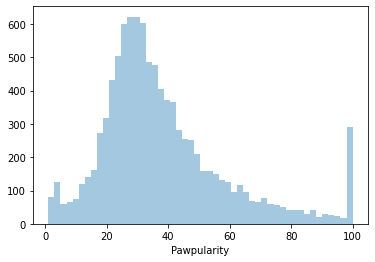

In [17]:
sns.distplot(train["Pawpularity"], kde=False)

# Preprocess

In [18]:
def get_transforms(*, data):
    if data == "train":
        return A.Compose(
            [
                # A.Resize(config.size, config.size),
                A.RandomResizedCrop(config.size, config.size),
                A.Transpose(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ShiftScaleRotate(p=0.5),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return A.Compose(
            [
                A.Resize(config.size, config.size),
                # A.CenterCrop(config.size, config.size),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

# EDA 2

# 👑 Load Artifacts

In [19]:
if Config.debug:
    train = train.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)
    if len(sub) > Config.num_debug_data:
        test = test.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)
        sub = sub.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)

# Utils

In [20]:
@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=config.seed)

# Make Fold

In [21]:
fold_ = StratifiedKFold(n_splits=config.n_fold, shuffle=True, random_state=seed)
for n, (train_index, val_index) in enumerate(fold_.split(train["Id"], train["Pawpularity"])):
    train.loc[val_index, "fold"] = int(n)
train["fold"] = train["fold"].astype(np.int8)
print(train.groupby(["fold"]).size())

fold
0    1983
1    1983
2    1982
3    1982
4    1982
dtype: int64


# Dataset

In [22]:
class BaseDataset(Dataset):
    def __init__(self, df, transform=None, label=True):
        self.df = df
        self.file_names = df["Id"].values
        self.transform = transform

        self.use_label = label
        if self.use_label:
            self.path = TRAIN_IMAGE_PATH
            self.labels = df["Pawpularity"].values / 100.0
        else:
            self.path = TEST_IMAGE_PATH

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{self.path}/{file_name}.jpg"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        if self.use_label:
            label = torch.tensor(self.labels[idx])
            return image, label
        return image

In [23]:
if Config.debug:
    train_ds = BaseDataset(train)
    image, label = train_ds[0]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()

In [24]:
if Config.debug:
    train_ds = BaseDataset(train, transform=get_transforms(data="valid"))
    image, label = train_ds[0]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()

# 🚗 Model

In [25]:
class BaseModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model_name = model_name
        self.model = timm.create_model(model_name, pretrained=pretrained)

        if "resnext50_32x4d" in model_name:
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, config.n_class)

        elif "efficientnet" in model_name:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, config.n_class)

        elif any(key in model_name for key in ["vit", "swin"]):
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, config.n_class)

    @amp.autocast(enabled=Config.amp)
    def forward(self, x):
        x = self.model(x)
        return x

In [26]:
if Config.debug and config.model_name != "":
    model = BaseModel(config.model_name)
    print(model)

    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

    for image, label in train_loader:
        output = model(image)
        print(output)
        break

# Optimizer

# Loss

In [27]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-7):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

# Scoring

In [28]:
def get_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [29]:
def get_result(result_df, fold=config.n_fold):
    preds = result_df["preds"].values
    labels = result_df["Pawpularity"].values
    score = get_score(labels, preds)
    LOGGER.info(f"Score: {score:<.5f}")
    if fold == config.n_fold:
        wandb.log({"Score": score})
    else:
        wandb.log({f"Score_fold{fold}": score})

# Helper functions

In [30]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

In [31]:
# https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path="checkpoint.pt", trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.best_preds = None

    def __call__(self, val_loss, score, model, preds):

        if self.best_score is None:
            self.best_score = score
            self.best_preds = preds
            self.save_checkpoint(val_loss, model)
        elif val_loss >= self.val_loss_min + self.delta:
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_preds = preds
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [32]:
def compute_grad_norm(parameters, norm_type=2.0):
    """Refer to torch.nn.utils.clip_grad_norm_"""
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    parameters = [p for p in parameters if p.grad is not None]
    norm_type = float(norm_type)
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm.item() ** norm_type
    total_norm = total_norm ** (1.0 / norm_type)
    return total_norm

In [33]:
def train_fn(train_loader, model, criterion, optimizer, scheduler, scaler, epoch, device):
    losses = AverageMeter()

    # switch to train mode
    model.train()
    start = time.time()
    optimizer.zero_grad()

    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with amp.autocast(enabled=Config.amp):
            # y_preds = model(images)
            y_preds = model(images).squeeze(1)
            loss = criterion(y_preds, labels)
            losses.update(loss.item(), batch_size)
            loss = loss / config.gradient_accumulation_steps

        scaler.scale(loss).backward()

        if (step + 1) % config.gradient_accumulation_steps == 0:
            scaler.unscale_(optimizer)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
            scaler.step(optimizer)
            scaler.update()

            scheduler.step()
            optimizer.zero_grad()
        else:
            grad_norm = compute_grad_norm(model.parameters())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                f"Epoch: [{epoch + 1}][{step}/{len(train_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(train_loader)):s} "
                f"Loss: {losses.avg:.4f} "
                f"Grad: {grad_norm:.4f} "
                f"LR: {scheduler.get_lr()[0]:.6f}  "
            )

    return losses.avg

In [34]:
def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = time.time()

    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            # y_preds = model(images)
            y_preds = model(images).squeeze(1)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # preds.append(y_preds.softmax(1).to("cpu").numpy())
        preds.append(y_preds.to("cpu").numpy())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                f"EVAL: [{step}/{len(valid_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(valid_loader)):s} "
                f"Loss: {losses.avg:.4f} "
            )

    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Postprocess

# 🏃‍♂️ Train loop

In [35]:
def train_loop(df, fold):
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = df[df["fold"] != fold].index
    val_idx = df[df["fold"] == fold].index

    train_folds = df.loc[trn_idx].reset_index(drop=True)
    valid_folds = df.loc[val_idx].reset_index(drop=True)

    train_dataset = BaseDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = BaseDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # Optimizer
    # ====================================================
    def get_optimizer(model):
        if config.optimizer == "Adam":
            optimizer = Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        elif config.optimizer == "AdamW":
            optimizer = T.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        return optimizer

    # ====================================================
    # Scheduler
    # ====================================================
    def get_scheduler(optimizer, train_folds):
        num_data = len(train_folds)
        num_steps = num_data // (config.batch_size * config.gradient_accumulation_steps) * config.epochs

        if config.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(
                optimizer, T_0=num_steps, T_mult=1, eta_min=config.min_lr, last_epoch=-1
            )
        elif config.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=num_steps, eta_min=config.min_lr, last_epoch=-1)
        elif config.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=num_steps,
                max_lr=config.lr,
                min_lr=config.min_lr,
                warmup_steps=(num_steps // 10),
            )
        return scheduler

    # ====================================================
    # Model
    # ====================================================
    model = BaseModel(config.model_name)
    if Config.multi_gpu:
        model = nn.DataParallel(model)
    model.to(device)

    optimizer = get_optimizer(model)
    scaler = amp.GradScaler(enabled=Config.amp)
    scheduler = get_scheduler(optimizer, train_folds)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if config.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif config.criterion == "BCEWithLogitsLoss":
            criterion = nn.BCEWithLogitsLoss()
        elif config.criterion == "MSELoss":
            criterion = nn.MSELoss()
        return criterion

    criterion = get_criterion()

    # ====================================================
    # Early stopping
    # ====================================================
    es = EarlyStopping(
        patience=config.es_patience,
        verbose=True,
        path=MODEL_DIR + f"{config.model_name.replace('/', '-')}_fold{fold}_best.pth",
    )
    
    # ====================================================
    # Loop
    # ====================================================
    best_score = -1
    best_loss = np.inf
    best_preds = None

    for epoch in range(config.epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, scheduler, scaler, epoch, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds["Pawpularity"].values

        if config.criterion == "BCEWithLogitsLoss":
            preds = 1 / (1 + np.exp(-preds))

        preds *= 100.0

        # scoring
        # score = get_score(valid_labels, preds.argmax(1))
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time
        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

        wandb.log(
            {
                "epoch": epoch + 1,
                f"loss/train_fold{fold}": avg_loss,
                f"loss/valid_fold{fold}": avg_val_loss,
                f"score/fold{fold}": score,
            }
        )

        es(avg_val_loss, score, model, preds)
        
        if es.early_stop:
            print("Early stopping")
            break

    # valid_folds[[str(c) for c in range(config.n_class)]] = es.best_preds
    # valid_folds["preds"] = es.best_preds.argmax(1)
    valid_folds["preds"] = es.best_preds

    return valid_folds, es.best_score, es.val_loss_min

# Main function

In [36]:
def main():
    # ====================================================
    # Training
    # ====================================================
    if Config.train:
        oof_df = pd.DataFrame()
        oof_result = []
        for fold in range(config.n_fold):
            seed_torch(seed + fold)

            _oof_df, score, loss = train_loop(train, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            oof_result.append([fold, score, loss])

            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df, fold)

        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)

        loss = statistics.mean([d[2] for d in oof_result])
        wandb.log({"loss": loss})

        table = wandb.Table(data=oof_result, columns=["fold", "score", "loss"])
        run.log({"Fold Result": table})

        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "oof_df.csv")

        artifact = wandb.Artifact(config.model_name, type="model")
        artifact.add_dir(MODEL_DIR)
        run.log_artifact(artifact)

# 🚀 Run

In [37]:
main()

========== fold: 0 training ==========
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window12_384_22k.pth" to /home/sugiyama/.cache/torch/hub/checkpoints/swin_base_patch4_window12_384_22k.pth


Epoch: [1][0/123] Elapsed 0m 25s (remain 52m 24s) Loss: 0.7021 Grad: 1.9864 LR: 0.000010  
Epoch: [1][100/123] Elapsed 1m 19s (remain 0m 17s) Loss: 0.6592 Grad: 0.7039 LR: 0.000010  
Epoch: [1][122/123] Elapsed 1m 30s (remain 0m 0s) Loss: 0.6563 Grad: 0.7838 LR: 0.000010  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 11s) Loss: 0.6714 


Epoch 1 - avg_train_loss: 0.6563  avg_val_loss: 0.6447  time: 104s
Epoch 1 - Score: 18.18920738325412


EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6447 
Validation loss decreased (inf --> 0.644689).  Saving model ...
Epoch: [2][0/123] Elapsed 0m 2s (remain 5m 20s) Loss: 0.6469 Grad: 0.6479 LR: 0.000010  
Epoch: [2][100/123] Elapsed 0m 55s (remain 0m 12s) Loss: 0.6415 Grad: 0.9361 LR: 0.000010  
Epoch: [2][122/123] Elapsed 1m 6s (remain 0m 0s) Loss: 0.6413 Grad: 0.6676 LR: 0.000010  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 5s) Loss: 0.6654 
EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6415 


Epoch 2 - avg_train_loss: 0.6413  avg_val_loss: 0.6415  time: 79s
Epoch 2 - Score: 17.781072311053325


Validation loss decreased (0.644689 --> 0.641477).  Saving model ...
Epoch: [3][0/123] Elapsed 0m 2s (remain 5m 30s) Loss: 0.6247 Grad: 0.6836 LR: 0.000010  
Epoch: [3][100/123] Elapsed 0m 55s (remain 0m 12s) Loss: 0.6349 Grad: 0.9158 LR: 0.000010  
Epoch: [3][122/123] Elapsed 1m 6s (remain 0m 0s) Loss: 0.6351 Grad: 0.7591 LR: 0.000010  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 15s) Loss: 0.6688 
EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6408 


Epoch 3 - avg_train_loss: 0.6351  avg_val_loss: 0.6408  time: 79s
Epoch 3 - Score: 17.68356616506945


Validation loss decreased (0.641477 --> 0.640842).  Saving model ...
Epoch: [4][0/123] Elapsed 0m 2s (remain 5m 35s) Loss: 0.6226 Grad: 0.6883 LR: 0.000010  
Epoch: [4][100/123] Elapsed 0m 55s (remain 0m 11s) Loss: 0.6276 Grad: 2.0567 LR: 0.000009  
Epoch: [4][122/123] Elapsed 1m 5s (remain 0m 0s) Loss: 0.6285 Grad: 1.2758 LR: 0.000009  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 11s) Loss: 0.6682 


Epoch 4 - avg_train_loss: 0.6285  avg_val_loss: 0.6415  time: 79s
Epoch 4 - Score: 17.759978757392904


EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6415 
EarlyStopping counter: 1 out of 5
Epoch: [5][0/123] Elapsed 0m 2s (remain 5m 28s) Loss: 0.6089 Grad: 0.8940 LR: 0.000009  
Epoch: [5][100/123] Elapsed 0m 55s (remain 0m 12s) Loss: 0.6215 Grad: 0.9356 LR: 0.000009  
Epoch: [5][122/123] Elapsed 1m 6s (remain 0m 0s) Loss: 0.6215 Grad: 1.0685 LR: 0.000009  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 19s) Loss: 0.6790 
EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6441 


Epoch 5 - avg_train_loss: 0.6215  avg_val_loss: 0.6441  time: 79s
Epoch 5 - Score: 18.03523322895825


EarlyStopping counter: 2 out of 5
Epoch: [6][0/123] Elapsed 0m 2s (remain 5m 40s) Loss: 0.5934 Grad: 0.9523 LR: 0.000009  
Epoch: [6][100/123] Elapsed 0m 56s (remain 0m 12s) Loss: 0.6136 Grad: 1.1981 LR: 0.000008  
Epoch: [6][122/123] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6127 Grad: 1.1494 LR: 0.000008  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 10s) Loss: 0.6891 


Epoch 6 - avg_train_loss: 0.6127  avg_val_loss: 0.6487  time: 81s
Epoch 6 - Score: 18.600532714882778


EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6487 
EarlyStopping counter: 3 out of 5
Epoch: [7][0/123] Elapsed 0m 2s (remain 5m 42s) Loss: 0.6300 Grad: 1.6374 LR: 0.000008  
Epoch: [7][100/123] Elapsed 0m 55s (remain 0m 12s) Loss: 0.6059 Grad: 1.9478 LR: 0.000008  
Epoch: [7][122/123] Elapsed 1m 6s (remain 0m 0s) Loss: 0.6064 Grad: 1.3933 LR: 0.000008  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 10s) Loss: 0.6833 
EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6469 


Epoch 7 - avg_train_loss: 0.6064  avg_val_loss: 0.6469  time: 79s
Epoch 7 - Score: 18.352355377321206


EarlyStopping counter: 4 out of 5
Epoch: [8][0/123] Elapsed 0m 2s (remain 5m 49s) Loss: 0.5735 Grad: 0.8503 LR: 0.000008  
Epoch: [8][100/123] Elapsed 0m 55s (remain 0m 12s) Loss: 0.5994 Grad: 1.0393 LR: 0.000007  
Epoch: [8][122/123] Elapsed 1m 6s (remain 0m 0s) Loss: 0.5992 Grad: 1.4891 LR: 0.000007  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 18s) Loss: 0.6929 


Epoch 8 - avg_train_loss: 0.5992  avg_val_loss: 0.6509  time: 80s
Epoch 8 - Score: 18.786584171871773
========== fold: 0 result ==========
Score: 17.68357
========== fold: 1 training ==========


EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6509 
EarlyStopping counter: 5 out of 5
Early stopping
Epoch: [1][0/123] Elapsed 0m 2s (remain 5m 51s) Loss: 0.7023 Grad: 2.1253 LR: 0.000010  
Epoch: [1][100/123] Elapsed 0m 56s (remain 0m 12s) Loss: 0.6529 Grad: 0.8759 LR: 0.000010  
Epoch: [1][122/123] Elapsed 1m 6s (remain 0m 0s) Loss: 0.6518 Grad: 0.7117 LR: 0.000010  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 18s) Loss: 0.6305 
EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6431 


Epoch 1 - avg_train_loss: 0.6518  avg_val_loss: 0.6431  time: 80s
Epoch 1 - Score: 17.97402407237852


Validation loss decreased (inf --> 0.643061).  Saving model ...
Epoch: [2][0/123] Elapsed 0m 2s (remain 6m 3s) Loss: 0.6491 Grad: 0.8118 LR: 0.000010  
Epoch: [2][100/123] Elapsed 0m 56s (remain 0m 12s) Loss: 0.6402 Grad: 0.7534 LR: 0.000010  
Epoch: [2][122/123] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6396 Grad: 0.6902 LR: 0.000010  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 10s) Loss: 0.6229 
EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6412 


Epoch 2 - avg_train_loss: 0.6396  avg_val_loss: 0.6412  time: 80s
Epoch 2 - Score: 17.720226053862177


Validation loss decreased (0.643061 --> 0.641210).  Saving model ...
Epoch: [3][0/123] Elapsed 0m 2s (remain 5m 55s) Loss: 0.6266 Grad: 1.1918 LR: 0.000010  
Epoch: [3][100/123] Elapsed 0m 57s (remain 0m 12s) Loss: 0.6325 Grad: 1.5810 LR: 0.000010  
Epoch: [3][122/123] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6338 Grad: 1.1677 LR: 0.000010  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 11s) Loss: 0.6207 


Epoch 3 - avg_train_loss: 0.6338  avg_val_loss: 0.6407  time: 81s


EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6407 


Epoch 3 - Score: 17.66449628228026


Validation loss decreased (0.641210 --> 0.640731).  Saving model ...
Epoch: [4][0/123] Elapsed 0m 2s (remain 5m 56s) Loss: 0.6202 Grad: 0.8960 LR: 0.000010  
Epoch: [4][100/123] Elapsed 0m 56s (remain 0m 12s) Loss: 0.6269 Grad: 1.1031 LR: 0.000009  
Epoch: [4][122/123] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6268 Grad: 1.5198 LR: 0.000009  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 15s) Loss: 0.6232 


Epoch 4 - avg_train_loss: 0.6268  avg_val_loss: 0.6428  time: 80s
Epoch 4 - Score: 17.852012858071653


EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6428 
EarlyStopping counter: 1 out of 5
Epoch: [5][0/123] Elapsed 0m 2s (remain 5m 38s) Loss: 0.6323 Grad: 1.4705 LR: 0.000009  
Epoch: [5][100/123] Elapsed 0m 56s (remain 0m 12s) Loss: 0.6207 Grad: 1.1388 LR: 0.000009  
Epoch: [5][122/123] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6198 Grad: 1.2048 LR: 0.000009  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 12s) Loss: 0.6238 


Epoch 5 - avg_train_loss: 0.6198  avg_val_loss: 0.6448  time: 81s
Epoch 5 - Score: 18.109419994196912


EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6448 
EarlyStopping counter: 2 out of 5
Epoch: [6][0/123] Elapsed 0m 2s (remain 5m 46s) Loss: 0.6063 Grad: 1.0657 LR: 0.000009  
Epoch: [6][100/123] Elapsed 0m 56s (remain 0m 12s) Loss: 0.6121 Grad: 1.3114 LR: 0.000008  
Epoch: [6][122/123] Elapsed 1m 6s (remain 0m 0s) Loss: 0.6116 Grad: 1.4437 LR: 0.000008  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 13s) Loss: 0.6218 


Epoch 6 - avg_train_loss: 0.6116  avg_val_loss: 0.6467  time: 80s
Epoch 6 - Score: 18.325112392970134


EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6467 
EarlyStopping counter: 3 out of 5
Epoch: [7][0/123] Elapsed 0m 2s (remain 5m 34s) Loss: 0.5993 Grad: 1.3719 LR: 0.000008  
Epoch: [7][100/123] Elapsed 0m 55s (remain 0m 12s) Loss: 0.6053 Grad: 1.8624 LR: 0.000008  
Epoch: [7][122/123] Elapsed 1m 6s (remain 0m 0s) Loss: 0.6038 Grad: 1.4808 LR: 0.000008  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 12s) Loss: 0.6248 
EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6493 


Epoch 7 - avg_train_loss: 0.6038  avg_val_loss: 0.6493  time: 80s
Epoch 7 - Score: 18.56326431163183


EarlyStopping counter: 4 out of 5
Epoch: [8][0/123] Elapsed 0m 2s (remain 5m 37s) Loss: 0.6092 Grad: 1.3581 LR: 0.000008  
Epoch: [8][100/123] Elapsed 0m 56s (remain 0m 12s) Loss: 0.5992 Grad: 1.0709 LR: 0.000007  
Epoch: [8][122/123] Elapsed 1m 7s (remain 0m 0s) Loss: 0.5983 Grad: 1.2093 LR: 0.000007  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 12s) Loss: 0.6232 
EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6524 


Epoch 8 - avg_train_loss: 0.5983  avg_val_loss: 0.6524  time: 80s
Epoch 8 - Score: 18.925302968126
========== fold: 1 result ==========
Score: 17.66450
========== fold: 2 training ==========


EarlyStopping counter: 5 out of 5
Early stopping
Epoch: [1][0/123] Elapsed 0m 2s (remain 5m 23s) Loss: 0.6872 Grad: 1.6578 LR: 0.000010  
Epoch: [1][100/123] Elapsed 0m 55s (remain 0m 12s) Loss: 0.6529 Grad: 0.5938 LR: 0.000010  
Epoch: [1][122/123] Elapsed 1m 6s (remain 0m 0s) Loss: 0.6514 Grad: 0.4454 LR: 0.000010  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 13s) Loss: 0.6592 


Epoch 1 - avg_train_loss: 0.6514  avg_val_loss: 0.6443  time: 79s
Epoch 1 - Score: 18.154186745632312


EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6443 
Validation loss decreased (inf --> 0.644320).  Saving model ...
Epoch: [2][0/123] Elapsed 0m 2s (remain 6m 2s) Loss: 0.6463 Grad: 0.4510 LR: 0.000010  
Epoch: [2][100/123] Elapsed 0m 55s (remain 0m 12s) Loss: 0.6399 Grad: 0.6208 LR: 0.000010  
Epoch: [2][122/123] Elapsed 1m 6s (remain 0m 0s) Loss: 0.6392 Grad: 0.6633 LR: 0.000010  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 21s) Loss: 0.6632 


Epoch 2 - avg_train_loss: 0.6392  avg_val_loss: 0.6431  time: 79s
Epoch 2 - Score: 17.979641350956808


EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6431 
Validation loss decreased (0.644320 --> 0.643140).  Saving model ...
Epoch: [3][0/123] Elapsed 0m 2s (remain 5m 39s) Loss: 0.6246 Grad: 0.6036 LR: 0.000010  
Epoch: [3][100/123] Elapsed 0m 55s (remain 0m 12s) Loss: 0.6325 Grad: 1.2983 LR: 0.000010  
Epoch: [3][122/123] Elapsed 1m 6s (remain 0m 0s) Loss: 0.6330 Grad: 0.7501 LR: 0.000010  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 19s) Loss: 0.6646 


Epoch 3 - avg_train_loss: 0.6330  avg_val_loss: 0.6432  time: 79s
Epoch 3 - Score: 18.00223039259268


EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6432 
EarlyStopping counter: 1 out of 5
Epoch: [4][0/123] Elapsed 0m 2s (remain 6m 5s) Loss: 0.6429 Grad: 0.7328 LR: 0.000010  
Epoch: [4][100/123] Elapsed 0m 57s (remain 0m 12s) Loss: 0.6262 Grad: 0.9886 LR: 0.000009  
Epoch: [4][122/123] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6268 Grad: 1.0194 LR: 0.000009  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 11s) Loss: 0.6699 


Epoch 4 - avg_train_loss: 0.6268  avg_val_loss: 0.6435  time: 81s
Epoch 4 - Score: 18.0157806171476


EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6435 
EarlyStopping counter: 2 out of 5
Epoch: [5][0/123] Elapsed 0m 3s (remain 6m 12s) Loss: 0.6100 Grad: 1.1879 LR: 0.000009  
Epoch: [5][100/123] Elapsed 0m 55s (remain 0m 12s) Loss: 0.6200 Grad: 0.9797 LR: 0.000009  
Epoch: [5][122/123] Elapsed 1m 6s (remain 0m 0s) Loss: 0.6199 Grad: 1.3834 LR: 0.000009  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 15s) Loss: 0.6781 


Epoch 5 - avg_train_loss: 0.6199  avg_val_loss: 0.6482  time: 79s
Epoch 5 - Score: 18.48730898529937


EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6482 
EarlyStopping counter: 3 out of 5
Epoch: [6][0/123] Elapsed 0m 2s (remain 5m 52s) Loss: 0.6096 Grad: 1.1987 LR: 0.000009  
Epoch: [6][100/123] Elapsed 0m 56s (remain 0m 12s) Loss: 0.6111 Grad: 1.1338 LR: 0.000008  
Epoch: [6][122/123] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6118 Grad: 1.7231 LR: 0.000008  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 14s) Loss: 0.6813 
EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6500 


Epoch 6 - avg_train_loss: 0.6118  avg_val_loss: 0.6500  time: 80s
Epoch 6 - Score: 18.66886603928171


EarlyStopping counter: 4 out of 5
Epoch: [7][0/123] Elapsed 0m 2s (remain 5m 46s) Loss: 0.6001 Grad: 1.1839 LR: 0.000008  
Epoch: [7][100/123] Elapsed 0m 55s (remain 0m 12s) Loss: 0.6056 Grad: 1.8872 LR: 0.000008  
Epoch: [7][122/123] Elapsed 1m 6s (remain 0m 0s) Loss: 0.6049 Grad: 1.3438 LR: 0.000008  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 12s) Loss: 0.6890 
EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6547 


Epoch 7 - avg_train_loss: 0.6049  avg_val_loss: 0.6547  time: 79s
Epoch 7 - Score: 19.130285444010827
========== fold: 2 result ==========
Score: 17.97964
========== fold: 3 training ==========


EarlyStopping counter: 5 out of 5
Early stopping
Epoch: [1][0/123] Elapsed 0m 2s (remain 5m 55s) Loss: 0.8005 Grad: 4.3991 LR: 0.000010  
Epoch: [1][100/123] Elapsed 0m 56s (remain 0m 12s) Loss: 0.6560 Grad: 1.0572 LR: 0.000010  
Epoch: [1][122/123] Elapsed 1m 6s (remain 0m 0s) Loss: 0.6544 Grad: 0.7197 LR: 0.000010  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 20s) Loss: 0.6376 
EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6426 


Epoch 1 - avg_train_loss: 0.6544  avg_val_loss: 0.6426  time: 80s
Epoch 1 - Score: 17.935701943971072


Validation loss decreased (inf --> 0.642610).  Saving model ...
Epoch: [2][0/123] Elapsed 0m 3s (remain 6m 7s) Loss: 0.6428 Grad: 1.2461 LR: 0.000010  
Epoch: [2][100/123] Elapsed 0m 56s (remain 0m 12s) Loss: 0.6384 Grad: 0.7206 LR: 0.000010  
Epoch: [2][122/123] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6391 Grad: 1.3826 LR: 0.000010  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 18s) Loss: 0.6364 


Epoch 2 - avg_train_loss: 0.6391  avg_val_loss: 0.6422  time: 81s
Epoch 2 - Score: 17.87461693873287


EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6422 
Validation loss decreased (0.642610 --> 0.642194).  Saving model ...
Epoch: [3][0/123] Elapsed 0m 3s (remain 6m 16s) Loss: 0.6308 Grad: 0.9440 LR: 0.000010  
Epoch: [3][100/123] Elapsed 0m 56s (remain 0m 12s) Loss: 0.6331 Grad: 1.6551 LR: 0.000010  
Epoch: [3][122/123] Elapsed 1m 6s (remain 0m 0s) Loss: 0.6327 Grad: 1.1270 LR: 0.000010  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 14s) Loss: 0.6390 


Epoch 3 - avg_train_loss: 0.6327  avg_val_loss: 0.6423  time: 80s
Epoch 3 - Score: 17.872209778765477


EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6423 
EarlyStopping counter: 1 out of 5
Epoch: [4][0/123] Elapsed 0m 2s (remain 5m 31s) Loss: 0.6462 Grad: 0.9109 LR: 0.000010  
Epoch: [4][100/123] Elapsed 0m 56s (remain 0m 12s) Loss: 0.6252 Grad: 1.2425 LR: 0.000009  
Epoch: [4][122/123] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6266 Grad: 1.9174 LR: 0.000009  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 11s) Loss: 0.6420 


Epoch 4 - avg_train_loss: 0.6266  avg_val_loss: 0.6439  time: 81s
Epoch 4 - Score: 18.066538033122466


EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6439 
EarlyStopping counter: 2 out of 5
Epoch: [5][0/123] Elapsed 0m 2s (remain 5m 56s) Loss: 0.6372 Grad: 1.5254 LR: 0.000009  
Epoch: [5][100/123] Elapsed 0m 57s (remain 0m 12s) Loss: 0.6187 Grad: 2.2047 LR: 0.000009  
Epoch: [5][122/123] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6181 Grad: 1.9208 LR: 0.000009  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 10s) Loss: 0.6443 


Epoch 5 - avg_train_loss: 0.6181  avg_val_loss: 0.6472  time: 81s
Epoch 5 - Score: 18.383123252091966


EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6472 
EarlyStopping counter: 3 out of 5
Epoch: [6][0/123] Elapsed 0m 2s (remain 5m 41s) Loss: 0.6096 Grad: 1.3912 LR: 0.000009  
Epoch: [6][100/123] Elapsed 0m 56s (remain 0m 12s) Loss: 0.6106 Grad: 2.9157 LR: 0.000008  
Epoch: [6][122/123] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6106 Grad: 1.9214 LR: 0.000008  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 12s) Loss: 0.6450 


Epoch 6 - avg_train_loss: 0.6106  avg_val_loss: 0.6495  time: 81s
Epoch 6 - Score: 18.662080172896424


EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6495 
EarlyStopping counter: 4 out of 5
Epoch: [7][0/123] Elapsed 0m 2s (remain 5m 37s) Loss: 0.5846 Grad: 1.7361 LR: 0.000008  
Epoch: [7][100/123] Elapsed 0m 57s (remain 0m 12s) Loss: 0.6026 Grad: 1.4824 LR: 0.000008  
Epoch: [7][122/123] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6032 Grad: 3.0460 LR: 0.000008  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 12s) Loss: 0.6510 
EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6531 


Epoch 7 - avg_train_loss: 0.6032  avg_val_loss: 0.6531  time: 81s
Epoch 7 - Score: 19.038605511528615
========== fold: 3 result ==========
Score: 17.87462
========== fold: 4 training ==========


EarlyStopping counter: 5 out of 5
Early stopping
Epoch: [1][0/123] Elapsed 0m 2s (remain 6m 2s) Loss: 0.7023 Grad: 1.7766 LR: 0.000010  
Epoch: [1][100/123] Elapsed 0m 56s (remain 0m 12s) Loss: 0.6542 Grad: 0.8006 LR: 0.000010  
Epoch: [1][122/123] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6532 Grad: 0.8652 LR: 0.000010  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 12s) Loss: 0.6418 


Epoch 1 - avg_train_loss: 0.6532  avg_val_loss: 0.6483  time: 80s
Epoch 1 - Score: 18.593488386829858


EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6483 
Validation loss decreased (inf --> 0.648259).  Saving model ...
Epoch: [2][0/123] Elapsed 0m 2s (remain 5m 35s) Loss: 0.6366 Grad: 1.1266 LR: 0.000010  
Epoch: [2][100/123] Elapsed 0m 56s (remain 0m 12s) Loss: 0.6377 Grad: 0.9662 LR: 0.000010  
Epoch: [2][122/123] Elapsed 1m 6s (remain 0m 0s) Loss: 0.6385 Grad: 0.9517 LR: 0.000010  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 15s) Loss: 0.6424 


Epoch 2 - avg_train_loss: 0.6385  avg_val_loss: 0.6456  time: 80s
Epoch 2 - Score: 18.26413058654688


EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6456 
Validation loss decreased (0.648259 --> 0.645640).  Saving model ...
Epoch: [3][0/123] Elapsed 0m 2s (remain 5m 45s) Loss: 0.6351 Grad: 0.8098 LR: 0.000010  
Epoch: [3][100/123] Elapsed 0m 55s (remain 0m 12s) Loss: 0.6326 Grad: 0.8978 LR: 0.000010  
Epoch: [3][122/123] Elapsed 1m 6s (remain 0m 0s) Loss: 0.6329 Grad: 1.2898 LR: 0.000010  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 12s) Loss: 0.6461 


Epoch 3 - avg_train_loss: 0.6329  avg_val_loss: 0.6462  time: 79s
Epoch 3 - Score: 18.297786515629774


EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6462 
EarlyStopping counter: 1 out of 5
Epoch: [4][0/123] Elapsed 0m 2s (remain 6m 3s) Loss: 0.6135 Grad: 1.3352 LR: 0.000010  
Epoch: [4][100/123] Elapsed 0m 56s (remain 0m 12s) Loss: 0.6253 Grad: 1.4536 LR: 0.000009  
Epoch: [4][122/123] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6257 Grad: 0.8490 LR: 0.000009  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 15s) Loss: 0.6509 
EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6470 


Epoch 4 - avg_train_loss: 0.6257  avg_val_loss: 0.6470  time: 81s
Epoch 4 - Score: 18.3652991068181


EarlyStopping counter: 2 out of 5
Epoch: [5][0/123] Elapsed 0m 2s (remain 6m 4s) Loss: 0.6299 Grad: 1.0571 LR: 0.000009  
Epoch: [5][100/123] Elapsed 0m 56s (remain 0m 12s) Loss: 0.6176 Grad: 1.5912 LR: 0.000009  
Epoch: [5][122/123] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6186 Grad: 1.2407 LR: 0.000009  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 13s) Loss: 0.6546 
EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6498 


Epoch 5 - avg_train_loss: 0.6186  avg_val_loss: 0.6498  time: 80s
Epoch 5 - Score: 18.680478780931296


EarlyStopping counter: 3 out of 5
Epoch: [6][0/123] Elapsed 0m 2s (remain 5m 38s) Loss: 0.6024 Grad: 1.2107 LR: 0.000009  
Epoch: [6][100/123] Elapsed 0m 57s (remain 0m 12s) Loss: 0.6107 Grad: 1.3069 LR: 0.000008  
Epoch: [6][122/123] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6113 Grad: 1.3369 LR: 0.000008  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 13s) Loss: 0.6662 


Epoch 6 - avg_train_loss: 0.6113  avg_val_loss: 0.6545  time: 81s


EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6545 


Epoch 6 - Score: 19.13935934570412


EarlyStopping counter: 4 out of 5
Epoch: [7][0/123] Elapsed 0m 2s (remain 5m 46s) Loss: 0.6125 Grad: 1.2369 LR: 0.000008  
Epoch: [7][100/123] Elapsed 0m 55s (remain 0m 12s) Loss: 0.6033 Grad: 3.8647 LR: 0.000008  
Epoch: [7][122/123] Elapsed 1m 6s (remain 0m 0s) Loss: 0.6041 Grad: 1.4651 LR: 0.000008  
EVAL: [0/31] Elapsed 0m 2s (remain 1m 23s) Loss: 0.6657 
EVAL: [30/31] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6547 


Epoch 7 - avg_train_loss: 0.6041  avg_val_loss: 0.6547  time: 79s
Epoch 7 - Score: 19.201712796036635
========== fold: 4 result ==========
Score: 18.26413
========== CV ==========
Score: 17.89460


EarlyStopping counter: 5 out of 5
Early stopping


wandb: Adding directory to artifact (./models)... Done. 3.1s


In [38]:
wandb.finish()

Score,17.8946
Score_fold0,17.68357
Score_fold1,17.6645
Score_fold2,17.97964
Score_fold3,17.87462
Score_fold4,18.26413
epoch,7
loss,0.64251
loss/train_fold0,0.59916
loss/train_fold1,0.59831
loss/train_fold2,0.60495


Score,▁
Score_fold0,▁
Score_fold1,▁
Score_fold2,▁
Score_fold3,▁
Score_fold4,▁
epoch,▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇▁▂▃▄▅▆▇▁▂▃▄▅▆▇
loss,▁
loss/train_fold0,█▆▅▅▄▃▂▁
loss/train_fold1,█▆▆▅▄▃▂▁
loss/train_fold2,█▆▅▄▃▂▁
